In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from merge import merge_func

import nltk
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud



Current Working Directory: /Users/robertwang/Documents/GitHub/Eodp-2nd-Asmt


In [2]:
ratings_file = 'BX-Ratings.csv'
books_file = 'BX-Books.csv'
users_file = 'BX-Users.csv'
output_file = 'Final_Merged.csv'

In [3]:
ratings = pd.read_csv(ratings_file)
books = pd.read_csv(books_file)
users = pd.read_csv(users_file)

In [4]:
books.head()
print(books.dtypes)

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Book-Publisher         object
dtype: object


In [5]:
# check missing data
missing_books = books.isna().sum()
print(missing_books)
print(" ")

missing_users = users.isna().sum()
print(missing_users)
print(" ")

missing_ratings = ratings.isna().sum()
print(missing_ratings)


ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Book-Publisher         0
dtype: int64
 
User-ID             0
User-City          61
User-State          0
User-Country      669
User-Age        18952
dtype: int64
 
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [6]:
# normalisation in users city, state, country

users["User-Country"] = users["User-Country"].str.replace('"', ' ').str.lower().str.strip().replace('', pd.NA)
users["User-City"] = users["User-City"].str.replace('"', ' ').str.lower().str.strip().replace('', pd.NA)
users["User-State"] = users["User-State"].str.replace('"', ' ').str.lower().str.strip().replace('', pd.NA)
users["User-Age"] = users["User-Age"].str.replace('"', ' ').replace('NaN', pd.NA).astype(float).astype('Int64')

users.to_csv('normalise_users.csv', index=False)
print(users)

       User-ID    User-City  User-State User-Country  User-Age
0            8      timmins     ontario       canada      <NA>
1            9   germantown   tennessee          usa      <NA>
2           16  albuquerque  new mexico          usa      <NA>
3           17   chesapeake    virginia          usa      <NA>
4           19       weston        <NA>          NaN        14
...        ...          ...         ...          ...       ...
48294   278846      toronto     ontario       canada        23
48295   278849   georgetown     ontario       canada        23
48296   278851       dallas       texas          usa        33
48297   278852     brisbane  queensland    australia        32
48298   278854     portland      oregon          usa      <NA>

[48299 rows x 5 columns]


In [7]:
missing_users = users.isna().sum()
print(missing_users)

User-ID             0
User-City          61
User-State        666
User-Country      669
User-Age        18952
dtype: int64


In [8]:
# filter out data has vaild state input
validstate_df = users.dropna(subset=['User-State'])

# create a dictionary mapping city to state
map_city_tostate = validstate_df.groupby('User-City')['User-State'].first().to_dict()
validstate_df

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,canada,<NA>
1,9,germantown,tennessee,usa,<NA>
2,16,albuquerque,new mexico,usa,<NA>
3,17,chesapeake,virginia,usa,<NA>
5,26,bellevue,washington,usa,<NA>
...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23
48295,278849,georgetown,ontario,canada,23
48296,278851,dallas,texas,usa,33
48297,278852,brisbane,queensland,australia,32


In [9]:
# filtered missing state
missing_state = users[users['User-State'].isnull()]
missing_state

,User-ID,User-City,User-State,User-Country,User-Age
4,19,weston,<NA>,NaN,14
133,777,portland,<NA>,NaN,13
160,929,king of prussia,<NA>,NaN,36
196,1118,cleveland,<NA>,usa,<NA>
198,1131,berkeley,<NA>,NaN,22
...,...,...,...,...,...
47869,276538,cologne,<NA>,NaN,26
47963,277124,NaN,<NA>,canada,<NA>
48138,277989,walker,<NA>,usa,39
48155,278112,middleburg hts,<NA>,usa,70


In [10]:
validstate_df.groupby('User-City').describe()

User-ID                                                         \
                 count      mean           std       min        25%       50%   
User-City                                                                       
&#321;ód&#378;     1.0  276113.0           NaN  276113.0  276113.00  276113.0   
*                  1.0  169893.0           NaN  169893.0  169893.00  169893.0   
***********        1.0   19842.0           NaN   19842.0   19842.00   19842.0   
-                  2.0   16486.5  22048.296544     896.0    8691.25   16486.5   
-----              1.0   53274.0           NaN   53274.0   53274.00   53274.0   
...                ...       ...           ...       ...        ...       ...   
águeda             2.0  179193.0  27759.598016  159564.0  169378.50  179193.0   
århus              1.0  122889.0           NaN  122889.0  122889.00  122889.0   
århus v            1.0  164991.0           NaN  164991.0  164991.00  164991.0   
évora              1.0  180757.0           NaN  180757.0  180757.00  180757.0   
øverbygd           1.0  177801.0           NaN  177801.0  177801.00  177801.0   

                                    User-Age                              \
                      75%       max    count  mean      std   min    25%   
User-City                                                                  
&#321;ód&#378;  276113.00  276113.0      1.0  21.0     <NA>  21.0   21.0   
*               169893.00  169893.0      0.0  <NA>     <NA>  <NA>   <NA>   
***********      19842.00   19842.0      0.0  <NA>     <NA>  <NA>   <NA>   
-                24281.75   32077.0      1.0  27.0     <NA>  27.0   27.0   
-----            53274.00   53274.0      0.0  <NA>     <NA>  <NA>   <NA>   
...                   ...       ...      ...   ...      ...   ...    ...   
águeda          189007.50  198822.0      2.0  34.5  2.12132  33.0  33.75   
århus           122889.00  122889.0      1.0  34.0     <NA>  34.0   34.0   
århus v         164991.00  164991.0      0.0  <NA>     <NA>  <NA>   <NA>   
évora           180757.00  180757.0      1.0  32.0     <NA>  32.0   32.0   
øverbygd        177801.00  177801.0      1.0  19.0     <NA>  19.0   19.0   

                                   
                 50%    75%   max  
User-City                          
&#321;ód&#378;  21.0   21.0  21.0  
*               <NA>   <NA>  <NA>  
***********     <NA>   <NA>  <NA>  
-               27.0   27.0  27.0  
-----           <NA>   <NA>  <NA>  
...              ...    ...   ...  
águeda          34.5  35.25  36.0  
århus           34.0   34.0  34.0  
århus v         <NA>   <NA>  <NA>  
évora           32.0   32.0  32.0  
øverbygd        19.0   19.0  19.0  

[9465 rows x 16 columns]

In [11]:
# base on the given state name, try to fill in missing country
for index, row in missing_state.iterrows():
    city = row['User-City']
    if city in map_city_tostate:
        users.at[index, 'User-State'] = map_city_tostate[city]

In [12]:
# filter out data has vaild country input
validcountry_df = users.dropna(subset=['User-Country'])

# create a dictionary mapping state to country
map_state_tocountry = validcountry_df.groupby('User-State')['User-Country'].first().to_dict()
validcountry_df


,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,canada,<NA>
1,9,germantown,tennessee,usa,<NA>
2,16,albuquerque,new mexico,usa,<NA>
3,17,chesapeake,virginia,usa,<NA>
5,26,bellevue,washington,usa,<NA>
...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23
48295,278849,georgetown,ontario,canada,23
48296,278851,dallas,texas,usa,33
48297,278852,brisbane,queensland,australia,32


In [13]:
# filtered missing country
missing_country = users[users['User-Country'].isnull()]
missing_country

,User-ID,User-City,User-State,User-Country,User-Age
4,19,weston,florida,NaN,14
133,777,portland,oregon,NaN,13
160,929,king of prussia,pennsylvania,NaN,36
198,1131,berkeley,california,NaN,22
284,1589,clio,michigan,NaN,50
...,...,...,...,...,...
47674,275358,pueblo,colorado,NaN,15
47827,276240,smyrna,georgia,NaN,28
47865,276496,the colony,texas,NaN,45
47869,276538,cologne,nordrhein-westfalen,NaN,26


In [14]:
validcountry_df.groupby('User-State')['User-Country'].describe()

,count,unique,top,freq
User-State,,,,
&#322;ódzkie,1,1,poland,1
(alacant),1,1,spain,1
(lisboa),1,1,portugal,1
*,1,1,netherlands,1
-,3,3,netherlands,1
...,...,...,...,...
zurich,11,1,switzerland,11
zürich,21,2,switzerland,20
álava,4,1,spain,4


In [15]:
# base on the given state name, try to fill in missing country
for index, row in missing_country.iterrows():
    state = row['User-State']
    if state in map_state_tocountry:
        users.at[index, 'User-Country'] = map_state_tocountry[state]

In [16]:
missing_country = users[users['User-Country'].isnull()]
missing_country

,User-ID,User-City,User-State,User-Country,User-Age
1913,11737,cesena,<NA>,NaN,31
3121,19320,conneautville,<NA>,NaN,47
4960,29725,rimini,<NA>,NaN,35
5403,31668,medowie,<NA>,NaN,28
7196,41533,upper lake,<NA>,NaN,54
7627,43873,pepinster,liege,NaN,43
8028,46199,kill devils hills,<NA>,NaN,62
11794,67663,wrightstown,<NA>,NaN,47
14561,84112,palm beach,<NA>,NaN,71
15088,87209,nancy,<NA>,NaN,21


In [17]:
# filter out data has vaild country input
validcountry_df = users.dropna(subset=['User-Country'])

# create a dictionary mapping city to country
map_city_tocountry = validcountry_df.groupby('User-City')['User-Country'].first().to_dict()
validcountry_df

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,canada,<NA>
1,9,germantown,tennessee,usa,<NA>
2,16,albuquerque,new mexico,usa,<NA>
3,17,chesapeake,virginia,usa,<NA>
4,19,weston,florida,usa,14
...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23
48295,278849,georgetown,ontario,canada,23
48296,278851,dallas,texas,usa,33
48297,278852,brisbane,queensland,australia,32


In [18]:
missing_users = users.isna().sum()
print(missing_users)

User-ID             0
User-City          61
User-State         85
User-Country       52
User-Age        18952
dtype: int64


In [19]:
# base on the given city name, try to fill in missing country
for index, row in missing_country.iterrows():
    city = row['User-City']
    if city in map_city_tocountry:
        users.at[index, 'User-Country'] = map_city_tocountry[city]

In [20]:
missing_users = users.isna().sum()
print(missing_users)

User-ID             0
User-City          61
User-State         85
User-Country       51
User-Age        18952
dtype: int64


In [21]:
missing_city = users[users['User-City'].isnull()]
missing_city

,User-ID,User-City,User-State,User-Country,User-Age
385,2197,NaN,travelling,canada,26
616,3569,NaN,n/a,usa,<NA>
731,4221,NaN,connecticut,usa,<NA>
1904,11676,NaN,n/a,n/a,<NA>
2107,12966,NaN,n/a,singapore,28
...,...,...,...,...,...
44878,258650,NaN,new south wales,australia,<NA>
45769,264128,NaN,n/a,austria,<NA>
45889,264846,NaN,n/a,netherlands,6
47048,271186,NaN,new jersey,usa,<NA>


In [22]:
missing_country = users[users['User-Country'].isnull()]
missing_country

,User-ID,User-City,User-State,User-Country,User-Age
1913,11737,cesena,<NA>,NaN,31
3121,19320,conneautville,<NA>,NaN,47
4960,29725,rimini,<NA>,NaN,35
5403,31668,medowie,<NA>,NaN,28
7196,41533,upper lake,<NA>,NaN,54
7627,43873,pepinster,liege,NaN,43
8028,46199,kill devils hills,<NA>,NaN,62
11794,67663,wrightstown,<NA>,NaN,47
14561,84112,palm beach,<NA>,NaN,71
15088,87209,nancy,<NA>,NaN,21


In [23]:
cleaned_users = users.dropna(subset=['User-City', 'User-State', 'User-Country'])
cleaned_users


,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,canada,<NA>
1,9,germantown,tennessee,usa,<NA>
2,16,albuquerque,new mexico,usa,<NA>
3,17,chesapeake,virginia,usa,<NA>
4,19,weston,florida,usa,14
...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23
48295,278849,georgetown,ontario,canada,23
48296,278851,dallas,texas,usa,33
48297,278852,brisbane,queensland,australia,32


In [24]:
missing_users = cleaned_users.isna().sum()
print(missing_users)

User-ID             0
User-City           0
User-State          0
User-Country        0
User-Age        18901
dtype: int64


In [25]:
na_columns = ['User-City', 'User-State', 'User-Country']
na_df = users[users[na_columns].isnull().any(axis=1)]
na_df

,User-ID,User-City,User-State,User-Country,User-Age
385,2197,NaN,travelling,canada,26
616,3569,NaN,n/a,usa,<NA>
731,4221,NaN,connecticut,usa,<NA>
1904,11676,NaN,n/a,n/a,<NA>
1913,11737,cesena,<NA>,NaN,31
...,...,...,...,...,...
47160,271844,elfin forest,<NA>,NaN,93
47582,274808,paynesville,<NA>,usa,17
47963,277124,NaN,<NA>,canada,<NA>
48155,278112,middleburg hts,<NA>,usa,70


In [26]:
users['User-Country'].value_counts()

User-Country
usa               34898
canada             4673
germany            1888
united kingdom     1793
australia           985
                  ...  
van wert              1
burma                 1
worcester             1
america               1
ghana                 1
Name: count, Length: 188, dtype: int64

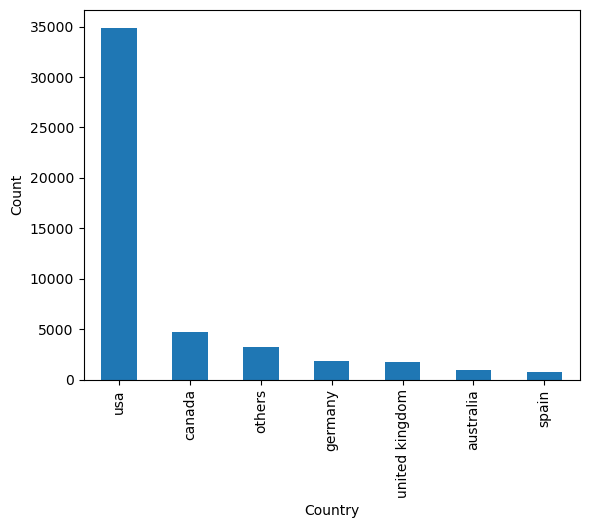

In [27]:
# identify countries have less than 10 users and combine them into a category called others
countries_to_combine = users['User-Country'].value_counts()[users['User-Country'].value_counts()<500].index

users.loc[users['User-Country'].isin(countries_to_combine), 'User-Country'] = "others"

users['User-Country'].value_counts().plot(kind='bar')

plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

In [28]:

#cleaned_users.loc[:, 'User-Age'] = pd.to_numeric(cleaned_users['User-Age'])
#cleaned_users['User-Age'] = cleaned_users['User-Age'].astype(float).astype('Int64')

# filter ages that are invalid (eg, greater than 100) which will later be grouped with nan value
# change empty entries to -1 which will be further group to others category
cleaned_users.loc[cleaned_users['User-Age'] > 100, 'User-Age'] = -1
cleaned_users['User-Age'].fillna(-1, inplace=True)
cleaned_users['User-Age'].astype(float).astype('Int64')
cleaned_users

/var/folders/2y/d2x11n9s4sbc3j2svdb5qdb00000gn/T/ipykernel_85739/1104086660.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_users['User-Age'].fillna(-1, inplace=True)
/var/folders/2y/d2x11n9s4sbc3j2svdb5qdb00000gn/T/ipykernel_85739/1104086660.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_users['User-Age'].fillna(-1, i

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,canada,-1
1,9,germantown,tennessee,usa,-1
2,16,albuquerque,new mexico,usa,-1
3,17,chesapeake,virginia,usa,-1
4,19,weston,florida,usa,14
...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23
48295,278849,georgetown,ontario,canada,23
48296,278851,dallas,texas,usa,33
48297,278852,brisbane,queensland,australia,32


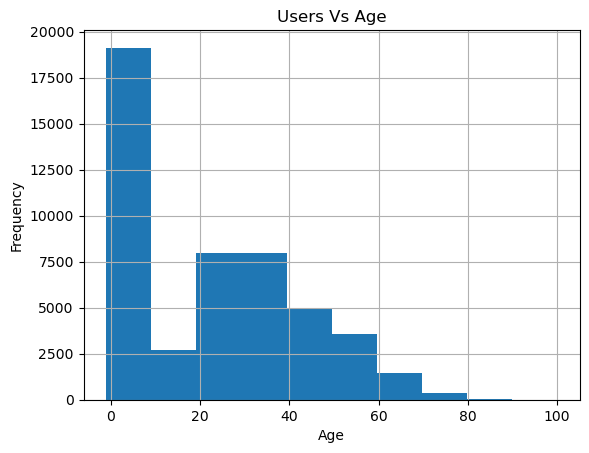

In [29]:
# check age distribution
cleaned_users['User-Age'].hist(bins=10)

plt.title('Users Vs Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show()

In [30]:
# group nan age into a group and discretisation
bins = [-float('inf'),0,20,40,60,80,100]
labels = ["others","0~20","20~40","40~60","60~80","80~100"]

cleaned_users['User-Age-Bin'] = pd.cut(cleaned_users['User-Age'], bins=bins, labels=labels, include_lowest=True)

missing_users = cleaned_users.isna().sum()
print(missing_users)
cleaned_users

User-ID         0
User-City       0
User-State      0
User-Country    0
User-Age        0
User-Age-Bin    0
dtype: int64


/var/folders/2y/d2x11n9s4sbc3j2svdb5qdb00000gn/T/ipykernel_85739/983409766.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_users['User-Age-Bin'] = pd.cut(cleaned_users['User-Age'], bins=bins, labels=labels, include_lowest=True)


,User-ID,User-City,User-State,User-Country,User-Age,User-Age-Bin
0,8,timmins,ontario,canada,-1,others
1,9,germantown,tennessee,usa,-1,others
2,16,albuquerque,new mexico,usa,-1,others
3,17,chesapeake,virginia,usa,-1,others
4,19,weston,florida,usa,14,0~20
...,...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23,20~40
48295,278849,georgetown,ontario,canada,23,20~40
48296,278851,dallas,texas,usa,33,20~40
48297,278852,brisbane,queensland,australia,32,20~40


<Axes: xlabel='User-Age-Bin'>

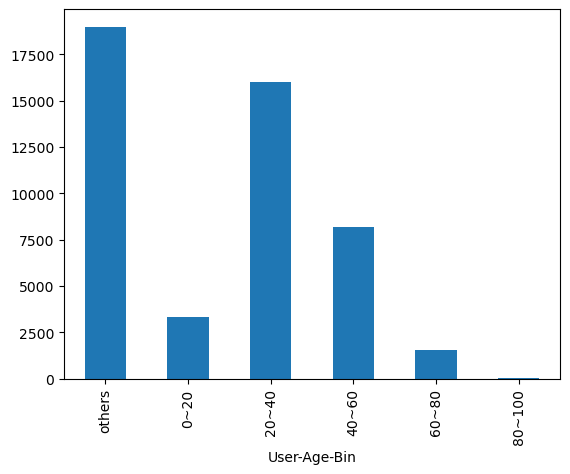

In [31]:
cleaned_users['User-Age-Bin'].value_counts().sort_index().plot(kind='bar')

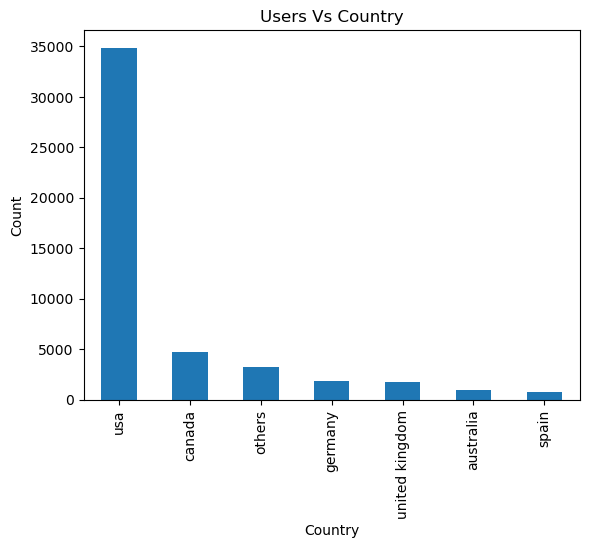

In [32]:
# identify countries have less than 10 users and combine them into a category called others
countries_to_combine = cleaned_users['User-Country'].value_counts()[cleaned_users['User-Country'].value_counts()<500].index

cleaned_users.loc[cleaned_users['User-Country'].isin(countries_to_combine), 'User-Country'] = "others"

cleaned_users['User-Country'].value_counts().plot(kind='bar')

plt.title('Users Vs Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

In [33]:
top5_state = cleaned_users.groupby('User-Country')['User-State'].value_counts().groupby(level=0).nlargest(5).reset_index(level=0, drop=True)
top_state_list = top5_state.index.get_level_values(1).tolist()

top_state_dic = {}
for country in top5_state.index.get_level_values(0).unique():
    top_state_dic[country] = top5_state.loc[country].index.tolist()[:5]

print(top_state_dic)

{'australia': ['new south wales', 'victoria', 'queensland', 'south australia', 'western australia'], 'canada': ['ontario', 'british columbia', 'alberta', 'quebec', 'nova scotia'], 'germany': ['nordrhein-westfalen', 'bayern', 'baden-wuerttemberg', 'hessen', 'niedersachsen'], 'others': ['n/a', 'lombardia', 'ile de france', 'lazio', 'lisboa'], 'spain': ['madrid', 'barcelona', 'catalunya', 'n/a', 'valencia'], 'united kingdom': ['england', 'scotland', 'n/a', 'wales', 'london'], 'usa': ['california', 'texas', 'new york', 'florida', 'washington']}


In [34]:
for index, row in cleaned_users.iterrows():
    if row['User-State'] not in top_state_dic.get(row['User-Country'], []):
        cleaned_users.at[index, 'User-State'] = 'others'

print(cleaned_users.head())

   User-ID    User-City User-State User-Country  User-Age User-Age-Bin
0        8      timmins    ontario       canada        -1       others
1        9   germantown     others          usa        -1       others
2       16  albuquerque     others          usa        -1       others
3       17   chesapeake     others          usa        -1       others
4       19       weston    florida          usa        14         0~20


In [35]:
cleaned_users.to_csv('cleaned_users.csv', index=False)
print(cleaned_users.dtypes)
cleaned_users

User-ID            int64
User-City         object
User-State        object
User-Country      object
User-Age           Int64
User-Age-Bin    category
dtype: object


,User-ID,User-City,User-State,User-Country,User-Age,User-Age-Bin
0,8,timmins,ontario,canada,-1,others
1,9,germantown,others,usa,-1,others
2,16,albuquerque,others,usa,-1,others
3,17,chesapeake,others,usa,-1,others
4,19,weston,florida,usa,14,0~20
...,...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23,20~40
48295,278849,georgetown,ontario,canada,23,20~40
48296,278851,dallas,texas,usa,33,20~40
48297,278852,brisbane,queensland,australia,32,20~40
